# Training a 1D Convolutional Neural Network for hyperspectral data classification

In this notebook, you will train and apply a one-dimensional convolutional neural network for classification of hyperspectral data from Luční Hora, Krkonoše mountains, Czechia.

First, we need to import external libraries:

- __os__ - Path manipulation
- __torch, torch.nn, torch.optim, torchnet__ - Pytorch related libraries for deep learning
- __numpy__ - Arrays to hold our data
- __matplotlib.pyplot__ - Draw images
- __sklearn.model_selection__ - Cross-validation implemented in scikit-learn
- __time.perf_counter__ - Track how long individual functions take to run
- __tqdm__ - show progress bars during training

- __image_preprocessing__ - Our library holding functions for image tiling, preprocessing, etc.
- __inference_utils__ - Our library for correctly exporting classifed images
- __visualisation_utils__ - Our library for visualising the data

One external library is not imported directly in this notebook, but it is used by functions in _image_preprocessing_ and _inference_utils_:

- __gdal__ - Manipulates spatial data

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchnet as tnt

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from time import perf_counter
from tqdm import notebook as tqdm

import image_preprocessing
import inference_utils
import visualisation_utils

# GLOBAL SETTINGS
plt.rcParams['figure.figsize'] = [4, 4]
np.set_printoptions(precision=2, suppress=True)  # Array print precision

Please fill correct paths to your training and reference rasters:

In [2]:
# PATHS TO TRAINING DATA
trainingdata_path = '../data/LH_202008_54bands_9cm.tif'
referencedata_path = '../data/LH_202008_reference.tif'

trainingdata_path = '../../data/Pavia_centre/Pavia.mat'
referencedata_path = '../../data/Pavia_centre/Pavia_gt.mat'

## 1. Loading and preprocessing training data

### 1.1. Data loading into NumPy
Let's start by reading an image into a numpy array, we do this in the background using GDAL.

The result of our function is a dictionary named _loaded_raster_, which contains two numpy arrays under keys _imagery_ and _reference_. As we can see, the loaded hyperspectral dataset has 1847 by 1563 pixels with 54 spectral bands. The raster containing our reference data has the same dimensions in height and width.

In [3]:
#loaded_raster = image_preprocessing.read_gdal(trainingdata_path, referencedata_path)
loaded_raster = image_preprocessing.read_pavia_centre(trainingdata_path, referencedata_path, out_shape=(1088, 1088, 102))

print(f'Tiled imagery shape {loaded_raster["imagery"].shape}')
print(f'Tiled reference shape {loaded_raster["reference"].shape}')

Tiled imagery shape (1088, 1088, 102)
Tiled reference shape (1088, 1088, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


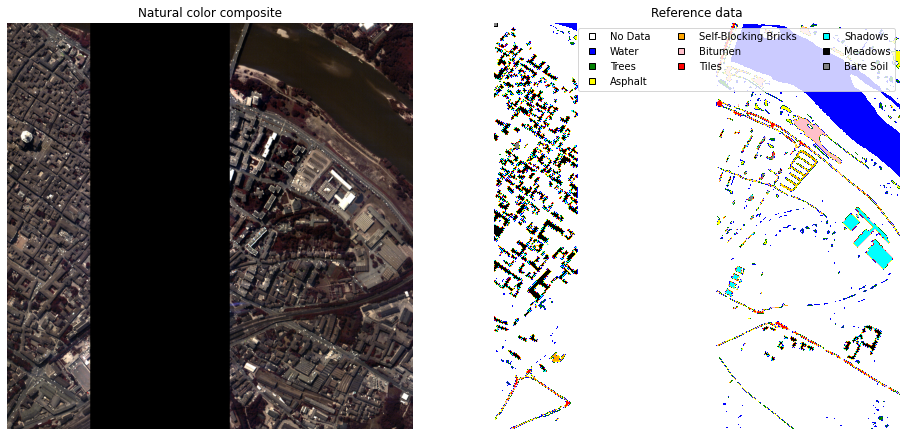

In [4]:
visualisation_utils.show_img_ref(loaded_raster["imagery"][:, :, [25, 15, 5]],
                                 loaded_raster["reference"])

### 1.2. Image tiling
We have our data loaded into a numpy array, the next step is to divide the image into individual tiles, which will be the input for our neural network.

As we want to perform convolution only in the spectral dimension, we need to divide the hyperspectral image into tiles of individual pixels, this is ensured by setting the variable _tile_shape_ as (1, 1).
_overlap_ and _offset_ are not needed for one-dimensional processing.

This process creates 2 886 861 "tiles" of 1 by 1 pixels, with the same amount of spectral bands as earlier.

In [5]:
tile_shape = (1, 1)
overlap = 0
offset = (0, 0)

dataset_tiles = image_preprocessing.tile_training(loaded_raster, tile_shape, overlap, offset)

print(f'Tiled imagery shape {dataset_tiles["imagery"].shape}')
print(f'Tiled reference shape {dataset_tiles["reference"].shape}')

Tiled imagery shape (1183744, 1, 1, 102)
Tiled reference shape (1183744, 1, 1, 1)


### 1.3. Tile filtration
However, most of the created tiles do not contain training data, we therefore need to filter them and only keep the tiles with a field-collected reference.

This process significantly reduces the size of our dataset from 2 886 861 to 49 842 - training data is available on less than 2 percent of the dataset.

In [6]:
filtered_tiles = image_preprocessing.filter_useful_tiles(dataset_tiles, nodata_vals=[0], is_training=True)

print(f'Filtered imagery shape {filtered_tiles["imagery"].shape}')
print(f'Filtered reference shape {filtered_tiles["reference"].shape}')

Filtered imagery shape (147920, 1, 1, 102)
Filtered reference shape (147920, 1, 1, 1)


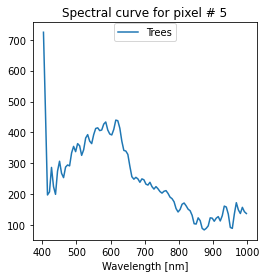

In [7]:
tile_number = 5
visualisation_utils.show_spectral_curve(filtered_tiles, tile_number)

### 1.4. Data normalization
After filtering the tiles to only include training data, we can move onto a final part of the preprocessing - data normalization. In Machine Learning, it is common to normalize all data before classification.

The resulting dictionary _preprocessed_tiles_ is subsequently transformed from numpy arrays into pytorch tensors for the training.

In [ ]:
preprocessed_tiles, unique, counts = image_preprocessing.normalize_tiles_1d(filtered_tiles, nodata_vals=[65535], is_training=True)
print(f'Preprocessed imagery shape {preprocessed_tiles["imagery"].shape}')
print(f'Preprocessed reference shape {preprocessed_tiles["reference"].shape}')

In [ ]:
tile_number = 5
visualisation_utils.show_spectral_curve(preprocessed_tiles, tile_number)

In [ ]:
dataset = tnt.dataset.TensorDataset([preprocessed_tiles['imagery'], preprocessed_tiles['reference']])
print(dataset)

print(f'Class labels: \n{unique}\n')
print(f'Number of pixels in a class: \n{counts}')

## 2. Neural network definition
After preprocessing our data, we can move onto defining our neural network and functions for training. You can either train your own neural network or use the one we already trained for you (_SpectralNet_pretrained.pt_). In case you are using the pretrained network, please run only the following code snippet (2.1.) and skip to section 3.

### 2.1. Network structure
Our network is named SpectralNet, and its structure is defined in the SpectralNet class, which has three methods:
- **__init__** - This method runs automatically when defining an instance of the class, it defines indiviudal layers of the networks (1D convolutions, fully connected layers, maxpooling and also a dropout layer).
- **init_weights** - Randomly initialising network weights based on a normal distribution.
- **forward** - Defining how data should flow through the network during a forward pass (network structure definition). The PyTorch library automatically creates a method for backward passes based on this structure.

In [ ]:
class SpectralNet(nn.Module):
    """1D CNN for classifying pixels based on the spectral response."""

    def __init__(self, args):
        """
        Initialize the SpectralNet model.

        n_channels, int, number of input channel
        size, int list, size of the feature maps of convs for the encoder
        n_class = int,  the number of classes
        """
        # necessary for all classes extending the module class
        super(SpectralNet, self).__init__()

        self.maxpool = nn.MaxPool1d(2, return_indices=False)
        self.dropout = nn.Dropout(p=0.5, inplace=False)

        self.n_channels = args['n_channel']
        self.size = args['layer_width']
        self.n_class = args['n_class']

        # Encoder layer definitions
        def conv_layer_1d(in_ch, out_ch, k_size=3, conv_bias=False):
            """Create default conv layer."""
            return nn.Sequential(nn.Conv1d(in_ch, out_ch, kernel_size=k_size,
                                           bias=conv_bias),
                                 nn.BatchNorm1d(out_ch), nn.ReLU())

        def fconnected_layer(in_ch, out_ch, mlp_bias=False):
            """Create default linear layer."""
            return nn.Sequential(nn.Linear(in_ch, out_ch, bias=mlp_bias),
                                 nn.BatchNorm1d(out_ch), nn.ReLU())

        self.c1 = conv_layer_1d(self.n_channels, self.size[0])
        self.c2 = conv_layer_1d(self.size[0], self.size[1])
        self.c3 = conv_layer_1d(self.size[1], self.size[2])

        self.c4 = conv_layer_1d(self.size[2], self.size[3])
        self.c5 = conv_layer_1d(self.size[3], self.size[4])
        self.c6 = conv_layer_1d(self.size[4], self.size[5])
        
        self.c7 = conv_layer_1d(self.size[5], self.size[6])
        self.c8 = conv_layer_1d(self.size[6], self.size[7])
        self.c9 = conv_layer_1d(self.size[7], self.size[8])

        self.flatten = nn.Flatten()

        self.l1 = fconnected_layer(self.size[9], self.size[10])
        self.l2 = fconnected_layer(self.size[10], self.size[11])
        self.l3 = fconnected_layer(self.size[11], self.size[12])
        # Final classifying layer
        self.classifier = nn.Linear(self.size[12], self.n_class)

        # Weight initialization
        self.c1[0].apply(self.init_weights)
        self.c2[0].apply(self.init_weights)
        self.c3[0].apply(self.init_weights)
        self.c4[0].apply(self.init_weights)
        self.c5[0].apply(self.init_weights)
        self.c6[0].apply(self.init_weights)
        self.c7[0].apply(self.init_weights)
        self.c8[0].apply(self.init_weights)
        self.c9[0].apply(self.init_weights)
        self.l1[0].apply(self.init_weights)
        self.l2[0].apply(self.init_weights)
        self.l3[0].apply(self.init_weights)

        self.classifier.apply(self.init_weights)

        if torch.cuda.is_available():  # Put the model on GPU memory
            self.cuda()
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True

    def init_weights(self, layer):
        """Initialise layer weights from a gaussian."""
        nn.init.kaiming_normal_(
            layer.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_data):
        """Define model structure for the forward pass."""
        # Encoder
        # Level 1
        x1 = self.c1(input_data)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.maxpool(x3)
        # Level 2
        x5 = self.c4(x4)
        x6 = self.c5(x5)
        x7 = self.c6(x6)
        x8 = self.maxpool(x7)
        # Level 3
        x9 = self.c7(x8)
        x10 = self.c8(x9)
        x11 = self.c9(x10)
        # Fully connected portion of the network (MLP)
        x12 = self.flatten(x11)
        x13 = self.l1(x12)
        x14 = self.l2(x13)
        x15 = self.l3(x14)
        # Output
        out = self.classifier(self.dropout(x15))

        return out

### 2.2. Functions for network training
Training the network is handled by four functions:
- __augment__ - Augments the training data by adding random noise.
- __train__ - Trains the network for one epoch. This function contains a for loop, which loads the training data in individual batches. Each batch of training data goes through the network, after which we compute the loss function (cross-entropy). Last step of training is performing an optimiser step, which changes the networks heights.
- __eval__ - Evaluates the results on a validation set, should be done periodically during training to check for overfitting.
- __train_full__ - Performs the full training loop.

__augment__ takes in the training tile and the corresponding reference labels. It then adds a random value (taken from a normal distribution) at each wavelength and thus slightly modifies the training data. Change _tile_number_ to see the augmentation effect for different spectral curves.

In [ ]:
def augment(obs, g_t):
    """the data augmentation function, introduces random noise."""
    sigma, clip= 0.002, 0.01
    rand = torch.clamp(torch.mul(sigma, torch.randn([1,1,54])), -clip, clip)
    obs = torch.add(obs, rand)

    return obs, g_t

In [ ]:
tile_number = 400
visualisation_utils.show_augment_spectral(preprocessed_tiles, tile_number, augment)

__train__ trains the network for one epoch. This function contains a for loop, which loads the training data in individual batches. Each batch of training data goes through the network, after which we compute the loss function (cross-entropy). Last step of training is performing an optimiser step, which changes the networks heights.

__eval__ evaluates the results on a validation set, should be done periodically during training to check for overfitting.

__train_full__ performs the full training loop.

In [ ]:
def train(model, optimizer, args):
    """train for one epoch"""
    model.train() #switch the model in training mode
  
    #the DataLoader class will take care of the batching
    loader = torch.utils.data.DataLoader(dataset, batch_size=args['batch_size'], sampler=args['train_subsampler'])
    loader = tqdm.tqdm(loader, ncols=500)
  
    #will keep track of the loss
    loss_meter = tnt.meter.AverageValueMeter()

    for index, (tiles, gt) in enumerate(loader):
    
        optimizer.zero_grad() #put gradient to zero

        tiles, gt = augment(tiles, gt)

        if torch.cuda.is_available():
            pred = model(tiles.cuda()) #compute the prediction
        else:
            pred = model(tiles)

        loss = nn.functional.cross_entropy(pred.cpu(), gt, weight=args['class_weights'])
        loss.backward() #compute gradients

        optimizer.step() #one SGD step
        loss_meter.add(loss.item())
        
    return loss_meter.value()[0]

def eval(model, sampler):
    """evaluate results on the validation set"""
  
    model.eval() #switch in eval mode
  
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=sampler)
    loader = tqdm.tqdm(loader, ncols=500)
  
    loss_meter = tnt.meter.AverageValueMeter()

    with torch.no_grad():
        for index, (tiles, gt) in enumerate(loader):
            if torch.cuda.is_available():
                pred = model(tiles.cuda())
                loss = nn.functional.cross_entropy(pred.cpu(), gt)
            else:
                pred = model(tiles)
                loss = nn.functional.cross_entropy(pred, gt)
            loss_meter.add(loss.item())

    return loss_meter.value()[0]


def train_full(args):
    """The full training loop"""

    #initialize the model
    model = SpectralNet(args)

    print(f'Total number of parameters: {sum([p.numel() for p in model.parameters()])}')
  
    #define the Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=args['scheduler_milestones'],
                                               gamma=args['scheduler_gamma'])
  
    train_loss = np.empty(args['n_epoch'])
    test_epochs = []
    test_loss = []

    for i_epoch in range(args['n_epoch']):
        #train one epoch
        print(f'Epoch #{str(i_epoch+1)}')
        train_loss[i_epoch] = train(model, optimizer, args)
        scheduler.step()

        # Periodic testing on the validation set
        if (i_epoch == args['n_epoch'] - 1) or ((i_epoch + 1) % args['n_epoch_test'] == 0):
            print('Evaluation')
            loss_test = eval(model, args['test_subsampler'])
            test_epochs.append(i_epoch + 1)
            test_loss.append(loss_test)

    plt.figure(figsize=(10, 10))
    plt.subplot(1,1,1,ylim=(0,5), xlabel='Epoch #', ylabel='Loss')
    plt.plot([i+1 for i in range(args['n_epoch'])], train_loss, label='Training loss')
    plt.plot(test_epochs, test_loss, label='Validation loss')
    plt.legend()
    plt.show()
    print(train_loss)
    print(test_loss)
    args['loss_test'] = test_loss[-1]
    
    return model

### 2.3. Hyperparameter definition
Training networks requires first setting several hyperparameters, please feel free to play around with them and try different values for the number of training epochs, learning rate or batch size.

- __n_channel__ - number of channels, set to 1 for our task
- __n_class__ - number of classification classes
- __layer_width__ - number of filters in each NN layer
- __crossval_nfolds__ - Number of folds for crossvalidation
- __n_epoch_test__ - after how many training epochs do we validate on the validation set
- __scheduler_milestones__ - after how many epochs do we reduce the training rate
- __scheduler_gamma__ - by what factor do we reduce the training rate
- __class_weights__ - training weights for individual classes, used to offset imbalanced class distribution

- __n_epoch__ - how many epochs are performed during training
- __lr__ - how fast can individual network parameters change during one training epoch
- __batch_size__ - how many tiles should be included in each gradient descent step

In [ ]:
args = { #Dict to store all model parameters
    'n_channel': 1,
    'n_class': len(unique),
    'layer_width': [32,32,32,64,64,64,128,128,128,384,384,192,96],

    'crossval_nfolds': 2,
    'n_epoch_test': 2,          #periodicity of evaluation on test set
    'scheduler_milestones': [60,80,95],
    'scheduler_gamma': 0.3,
    'class_weights': torch.tensor([0.2, 0.34, 0.033, 0.16, 0.14, 0.03, 0.014, 0.023, 0.06]),

    'n_epoch': 5,
    'lr': 1e-5,
    'batch_size': 64,
}
model_save_folder = '../models/1D'

print(f'''Number of models to be trained:
    {args['crossval_nfolds']}
Initial learning rate:
    {args['lr']}
Batch size:
    {args['batch_size']}
Number of training epochs:
    {args['n_epoch']}''')

### 2.4 Network training

In [ ]:
kfold = StratifiedKFold(n_splits = args['crossval_nfolds'], shuffle=True)
trained_models = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, preprocessed_tiles['reference'])):
    print(f'Training starts for model number {str(fold+1)}')
    
    a = perf_counter()
    args['train_subsampler'] = torch.utils.data.SubsetRandomSampler(train_ids)
    args['test_subsampler'] = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trained_models.append((train_full(args), args['loss_test']))
    
    state_dict_path = os.path.join(model_save_folder, f'fold_{str(fold)}.pt')
    torch.save(trained_models[fold][0].state_dict(), state_dict_path)
    print(f'Model saved to: {state_dict_path}')
    
    print(f'Training finished in {visualisation_utils.sec_to_hms(perf_counter()-a)}.')
    print('\n\n')

print(f'Resulting loss for individual folds: \n{[i for _, i in trained_models]}')
print(f'Mean loss across all folds: \n{np.mean([i for _, i in trained_models])}')

## 3. Applying the network

### 3.1. Loading a trained model

In [ ]:
# Parameters for model definition
args = {
    'n_channel': 1,
    'n_class': 9,
    'layer_width': [32,32,32,64,64,64,128,128,128,384,384,192,96],
}
# Path to the state dictionary
state_dict_path = '../models/1D/fold_1.pt'

In [ ]:
model = SpectralNet(args)
model.load_state_dict(torch.load(state_dict_path))
model.eval()

### 3.2. Loading and preprocessing the data

In [ ]:
source_path = '../data/LH_202008_54bands_9cm.tif'
tile_shape = (1, 1)
overlap = 0
offset_topleft = (0, 0)

In [ ]:
start = perf_counter()
raster_orig = image_preprocessing.read_gdal_with_geoinfo(source_path, offset_topleft)
dataset_full_tiles = image_preprocessing.run_tiling_dims(raster_orig['imagery'], out_shape=tile_shape, 
                                                    out_overlap=overlap, offset=offset_topleft)
dataset_full = image_preprocessing.normalize_tiles_1d(dataset_full_tiles, nodata_vals=[0])
dataset = tnt.dataset.TensorDataset(dataset_full['imagery'])
end = perf_counter()

print('Geoinformation extracted from the original raster:')
print(raster_orig['geoinfo'])
print('')
print(f'Loading and preprocessing the imagery took {visualisation_utils.sec_to_hms(end - start)}.')

### 3.3. Applying the CNN and exporting results
The following snippet applies the CNN and exports the resulting classified raster into _output_path_ for further analysis (e.g. validation in GIS):
This may take several hours, given that the network has to be applied almost 2 900 000 times (1847 * 1563 = 2 886 861).

In [ ]:
output_path = '../results/test_result_1d.tif'

start = perf_counter()
arr_class = inference_utils.combine_tiles_1d(model, dataset, tile_shape, overlap, dataset_full_tiles['dimensions'])
print(f'Model applied to all tiles in {visualisation_utils.sec_to_hms(perf_counter() - start)}.')

inference_utils.export_result(output_path, arr_class, raster_orig['geoinfo'])
print(f'The entire processing took {visualisation_utils.sec_to_hms(perf_counter() - start)}.')

You can also visualise the result:

In [ ]:
visualisation_utils.show_classified(raster_orig['imagery'][:, :, [25, 15, 5]],
                                    loaded_raster['reference'], arr_class)